### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal-Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Run locally

In [ ]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known and not used (model-free).

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v0')

In [2]:
class MyRandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

# Usefull tools
Many times, it will be necessary for us to calculate the discount return $G_t = \sum_{t}^T\gamma R_t$. For that, we use optimized discount_cumsum function. Example

In [5]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.9
discount_cumsum(episode_reward, gamma)

array([ 4.14590522,  4.60656136,  5.11840151,  5.68711279,  5.2079031 ,
        5.786559  ,  6.42951   ,  7.1439    ,  8.271     ,  9.19      ,
        9.1       ,  9.        , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

In [30]:
#TODO: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=500):
    discount_empirical_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_empirical_returns.append(None)#complete here
    return np.hstack(discount_empirical_returns)

In [102]:
#Done: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=50):
    discount_empirical_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_empirical_returns.append(discount_cumsum(rewards, gamma))
    return np.hstack(discount_empirical_returns)

In [103]:
res = get_G(env)
res.shape

(344,)

And to compute the trajectories $(S,A,R,G)_\pi$:

In [ ]:
#TODO: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(None) # complete here
    return np.vstack(trajectories)

In [104]:
#Done: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(np.c_[discount_empirical_return.reshape(-1,1), episode])
    return np.vstack(trajectories)

In [105]:
res = get_trajectories(env)
print(res.shape)
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(324, 4)


# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}



[
$\frac{\sum_{i=1}^n \mathbb{1}[S_i = s] G_i}{\sum_{i=1}^n \mathbb{1}[S_i = s]} $
is convergent if $G_{s_i}$ is Independent and identically distributed.
]


remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

In [6]:
#TODO: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                Gt_state = discount_empirical_return[episode[:,0] == state].sum()
                V[state] += None #complete here
    return V

In [19]:
#Done: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - N_trajectory[state] * V[state]) / count
    return V

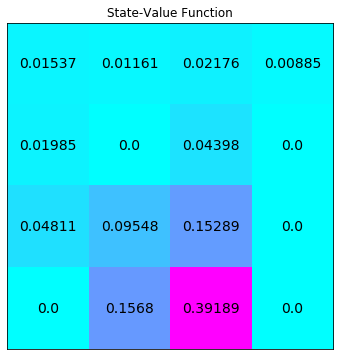

In [20]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

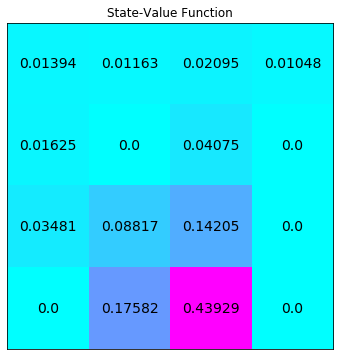

In [21]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [22]:
V.sum()

0.9941411498416601

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

In [23]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

In [107]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, baseline = 1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) * baseline
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # collect trajectories
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True: # we train the agent at every end of episode
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)): # evaluate Q
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 :
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n): # get policy from Q
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 337 - cum reward 0.0
episode: 338 - cum reward 0.0
episode: 339 - cum reward 0.0
episode: 340 - cum reward 0.0
episode: 341 - cum reward 0.0
episode: 342 - cum reward 0.0
episode: 343 - cum reward 0.0
episode: 344 - cum reward 0.0
episode: 345 - cum reward 0.0
episode: 346 - cum reward 1.0
episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 1.0
episode: 351 - cum reward 1.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 1.0
episode: 356 - cum reward 1.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 1.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 3

episode: 683 - cum reward 1.0
episode: 684 - cum reward 0.0
episode: 685 - cum reward 0.0
episode: 686 - cum reward 0.0
episode: 687 - cum reward 0.0
episode: 688 - cum reward 0.0
episode: 689 - cum reward 0.0
episode: 690 - cum reward 0.0
episode: 691 - cum reward 0.0
episode: 692 - cum reward 1.0
episode: 693 - cum reward 0.0
episode: 694 - cum reward 0.0
episode: 695 - cum reward 0.0
episode: 696 - cum reward 0.0
episode: 697 - cum reward 0.0
episode: 698 - cum reward 0.0
episode: 699 - cum reward 1.0
episode: 700 - cum reward 1.0
episode: 701 - cum reward 0.0
episode: 702 - cum reward 0.0
episode: 703 - cum reward 0.0
episode: 704 - cum reward 0.0
episode: 705 - cum reward 0.0
episode: 706 - cum reward 0.0
episode: 707 - cum reward 0.0
episode: 708 - cum reward 1.0
episode: 709 - cum reward 0.0
episode: 710 - cum reward 0.0
episode: 711 - cum reward 1.0
episode: 712 - cum reward 1.0
episode: 713 - cum reward 0.0
episode: 714 - cum reward 0.0
episode: 715 - cum reward 0.0
episode: 7

episode: 997 - cum reward 1.0
episode: 998 - cum reward 1.0
episode: 999 - cum reward 0.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 1.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 1.0
episode: 1004 - cum reward 1.0
episode: 1005 - cum reward 1.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.0
episode: 1012 - cum reward 1.0
episode: 1013 - cum reward 0.0
episode: 1014 - cum reward 0.0
episode: 1015 - cum reward 1.0
episode: 1016 - cum reward 1.0
episode: 1017 - cum reward 0.0
episode: 1018 - cum reward 1.0
episode: 1019 - cum reward 0.0
episode: 1020 - cum reward 1.0
episode: 1021 - cum reward 0.0
episode: 1022 - cum reward 1.0
episode: 1023 - cum reward 0.0
episode: 1024 - cum reward 0.0
episode: 1025 - cum reward 1.0
episode: 1026 - cum reward 0.0
episode: 1027 - cum reward 1.0
episode: 1028 - cum reward 0.0
episode: 10

episode: 1311 - cum reward 0.0
episode: 1312 - cum reward 0.0
episode: 1313 - cum reward 1.0
episode: 1314 - cum reward 0.0
episode: 1315 - cum reward 0.0
episode: 1316 - cum reward 1.0
episode: 1317 - cum reward 0.0
episode: 1318 - cum reward 1.0
episode: 1319 - cum reward 0.0
episode: 1320 - cum reward 0.0
episode: 1321 - cum reward 0.0
episode: 1322 - cum reward 0.0
episode: 1323 - cum reward 1.0
episode: 1324 - cum reward 0.0
episode: 1325 - cum reward 1.0
episode: 1326 - cum reward 0.0
episode: 1327 - cum reward 0.0
episode: 1328 - cum reward 1.0
episode: 1329 - cum reward 1.0
episode: 1330 - cum reward 0.0
episode: 1331 - cum reward 0.0
episode: 1332 - cum reward 0.0
episode: 1333 - cum reward 1.0
episode: 1334 - cum reward 1.0
episode: 1335 - cum reward 1.0
episode: 1336 - cum reward 0.0
episode: 1337 - cum reward 1.0
episode: 1338 - cum reward 0.0
episode: 1339 - cum reward 1.0
episode: 1340 - cum reward 0.0
episode: 1341 - cum reward 0.0
episode: 1342 - cum reward 1.0
episode:

episode: 1624 - cum reward 0.0
episode: 1625 - cum reward 1.0
episode: 1626 - cum reward 0.0
episode: 1627 - cum reward 0.0
episode: 1628 - cum reward 0.0
episode: 1629 - cum reward 1.0
episode: 1630 - cum reward 1.0
episode: 1631 - cum reward 1.0
episode: 1632 - cum reward 0.0
episode: 1633 - cum reward 1.0
episode: 1634 - cum reward 0.0
episode: 1635 - cum reward 1.0
episode: 1636 - cum reward 1.0
episode: 1637 - cum reward 0.0
episode: 1638 - cum reward 0.0
episode: 1639 - cum reward 0.0
episode: 1640 - cum reward 1.0
episode: 1641 - cum reward 0.0
episode: 1642 - cum reward 1.0
episode: 1643 - cum reward 0.0
episode: 1644 - cum reward 0.0
episode: 1645 - cum reward 0.0
episode: 1646 - cum reward 0.0
episode: 1647 - cum reward 0.0
episode: 1648 - cum reward 0.0
episode: 1649 - cum reward 0.0
episode: 1650 - cum reward 0.0
episode: 1651 - cum reward 0.0
episode: 1652 - cum reward 1.0
episode: 1653 - cum reward 1.0
episode: 1654 - cum reward 0.0
episode: 1655 - cum reward 0.0
episode:

episode: 1946 - cum reward 0.0
episode: 1947 - cum reward 0.0
episode: 1948 - cum reward 1.0
episode: 1949 - cum reward 0.0
episode: 1950 - cum reward 0.0
episode: 1951 - cum reward 0.0
episode: 1952 - cum reward 0.0
episode: 1953 - cum reward 1.0
episode: 1954 - cum reward 0.0
episode: 1955 - cum reward 0.0
episode: 1956 - cum reward 0.0
episode: 1957 - cum reward 0.0
episode: 1958 - cum reward 1.0
episode: 1959 - cum reward 0.0
episode: 1960 - cum reward 1.0
episode: 1961 - cum reward 0.0
episode: 1962 - cum reward 1.0
episode: 1963 - cum reward 0.0
episode: 1964 - cum reward 1.0
episode: 1965 - cum reward 0.0
episode: 1966 - cum reward 0.0
episode: 1967 - cum reward 0.0
episode: 1968 - cum reward 1.0
episode: 1969 - cum reward 0.0
episode: 1970 - cum reward 1.0
episode: 1971 - cum reward 1.0
episode: 1972 - cum reward 0.0
episode: 1973 - cum reward 0.0
episode: 1974 - cum reward 1.0
episode: 1975 - cum reward 0.0
episode: 1976 - cum reward 0.0
episode: 1977 - cum reward 0.0
episode:

episode: 2254 - cum reward 0.0
episode: 2255 - cum reward 1.0
episode: 2256 - cum reward 1.0
episode: 2257 - cum reward 1.0
episode: 2258 - cum reward 1.0
episode: 2259 - cum reward 0.0
episode: 2260 - cum reward 0.0
episode: 2261 - cum reward 0.0
episode: 2262 - cum reward 1.0
episode: 2263 - cum reward 0.0
episode: 2264 - cum reward 1.0
episode: 2265 - cum reward 0.0
episode: 2266 - cum reward 1.0
episode: 2267 - cum reward 0.0
episode: 2268 - cum reward 0.0
episode: 2269 - cum reward 0.0
episode: 2270 - cum reward 1.0
episode: 2271 - cum reward 0.0
episode: 2272 - cum reward 0.0
episode: 2273 - cum reward 0.0
episode: 2274 - cum reward 0.0
episode: 2275 - cum reward 1.0
episode: 2276 - cum reward 1.0
episode: 2277 - cum reward 0.0
episode: 2278 - cum reward 0.0
episode: 2279 - cum reward 0.0
episode: 2280 - cum reward 0.0
episode: 2281 - cum reward 0.0
episode: 2282 - cum reward 1.0
episode: 2283 - cum reward 0.0
episode: 2284 - cum reward 0.0
episode: 2285 - cum reward 0.0
episode:

episode: 2570 - cum reward 1.0
episode: 2571 - cum reward 0.0
episode: 2572 - cum reward 0.0
episode: 2573 - cum reward 1.0
episode: 2574 - cum reward 1.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 1.0
episode: 2578 - cum reward 0.0
episode: 2579 - cum reward 0.0
episode: 2580 - cum reward 0.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 0.0
episode: 2583 - cum reward 1.0
episode: 2584 - cum reward 0.0
episode: 2585 - cum reward 0.0
episode: 2586 - cum reward 1.0
episode: 2587 - cum reward 0.0
episode: 2588 - cum reward 1.0
episode: 2589 - cum reward 1.0
episode: 2590 - cum reward 0.0
episode: 2591 - cum reward 0.0
episode: 2592 - cum reward 1.0
episode: 2593 - cum reward 0.0
episode: 2594 - cum reward 0.0
episode: 2595 - cum reward 1.0
episode: 2596 - cum reward 0.0
episode: 2597 - cum reward 1.0
episode: 2598 - cum reward 1.0
episode: 2599 - cum reward 0.0
episode: 2600 - cum reward 1.0
episode: 2601 - cum reward 0.0
episode:

episode: 2873 - cum reward 1.0
episode: 2874 - cum reward 0.0
episode: 2875 - cum reward 0.0
episode: 2876 - cum reward 1.0
episode: 2877 - cum reward 0.0
episode: 2878 - cum reward 0.0
episode: 2879 - cum reward 0.0
episode: 2880 - cum reward 1.0
episode: 2881 - cum reward 0.0
episode: 2882 - cum reward 1.0
episode: 2883 - cum reward 0.0
episode: 2884 - cum reward 0.0
episode: 2885 - cum reward 0.0
episode: 2886 - cum reward 0.0
episode: 2887 - cum reward 0.0
episode: 2888 - cum reward 0.0
episode: 2889 - cum reward 1.0
episode: 2890 - cum reward 1.0
episode: 2891 - cum reward 1.0
episode: 2892 - cum reward 0.0
episode: 2893 - cum reward 1.0
episode: 2894 - cum reward 0.0
episode: 2895 - cum reward 0.0
episode: 2896 - cum reward 1.0
episode: 2897 - cum reward 0.0
episode: 2898 - cum reward 0.0
episode: 2899 - cum reward 1.0
episode: 2900 - cum reward 0.0
episode: 2901 - cum reward 0.0
episode: 2902 - cum reward 1.0
episode: 2903 - cum reward 0.0
episode: 2904 - cum reward 1.0
episode:

episode: 3192 - cum reward 0.0
episode: 3193 - cum reward 1.0
episode: 3194 - cum reward 1.0
episode: 3195 - cum reward 1.0
episode: 3196 - cum reward 1.0
episode: 3197 - cum reward 0.0
episode: 3198 - cum reward 1.0
episode: 3199 - cum reward 0.0
episode: 3200 - cum reward 1.0
episode: 3201 - cum reward 1.0
episode: 3202 - cum reward 1.0
episode: 3203 - cum reward 0.0
episode: 3204 - cum reward 1.0
episode: 3205 - cum reward 1.0
episode: 3206 - cum reward 1.0
episode: 3207 - cum reward 1.0
episode: 3208 - cum reward 0.0
episode: 3209 - cum reward 0.0
episode: 3210 - cum reward 1.0
episode: 3211 - cum reward 1.0
episode: 3212 - cum reward 0.0
episode: 3213 - cum reward 1.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 0.0
episode: 3216 - cum reward 0.0
episode: 3217 - cum reward 0.0
episode: 3218 - cum reward 0.0
episode: 3219 - cum reward 1.0
episode: 3220 - cum reward 1.0
episode: 3221 - cum reward 0.0
episode: 3222 - cum reward 1.0
episode: 3223 - cum reward 0.0
episode:

episode: 3501 - cum reward 0.0
episode: 3502 - cum reward 0.0
episode: 3503 - cum reward 0.0
episode: 3504 - cum reward 0.0
episode: 3505 - cum reward 0.0
episode: 3506 - cum reward 0.0
episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 1.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 0.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 1.0
episode: 3514 - cum reward 1.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 1.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 1.0
episode: 3520 - cum reward 1.0
episode: 3521 - cum reward 0.0
episode: 3522 - cum reward 0.0
episode: 3523 - cum reward 1.0
episode: 3524 - cum reward 0.0
episode: 3525 - cum reward 0.0
episode: 3526 - cum reward 0.0
episode: 3527 - cum reward 0.0
episode: 3528 - cum reward 0.0
episode: 3529 - cum reward 0.0
episode: 3530 - cum reward 0.0
episode: 3531 - cum reward 1.0
episode: 3532 - cum reward 1.0
episode:

episode: 3782 - cum reward 1.0
episode: 3783 - cum reward 0.0
episode: 3784 - cum reward 1.0
episode: 3785 - cum reward 0.0
episode: 3786 - cum reward 0.0
episode: 3787 - cum reward 1.0
episode: 3788 - cum reward 0.0
episode: 3789 - cum reward 0.0
episode: 3790 - cum reward 0.0
episode: 3791 - cum reward 0.0
episode: 3792 - cum reward 0.0
episode: 3793 - cum reward 0.0
episode: 3794 - cum reward 1.0
episode: 3795 - cum reward 0.0
episode: 3796 - cum reward 0.0
episode: 3797 - cum reward 0.0
episode: 3798 - cum reward 1.0
episode: 3799 - cum reward 1.0
episode: 3800 - cum reward 1.0
episode: 3801 - cum reward 0.0
episode: 3802 - cum reward 0.0
episode: 3803 - cum reward 0.0
episode: 3804 - cum reward 1.0
episode: 3805 - cum reward 0.0
episode: 3806 - cum reward 0.0
episode: 3807 - cum reward 1.0
episode: 3808 - cum reward 1.0
episode: 3809 - cum reward 1.0
episode: 3810 - cum reward 1.0
episode: 3811 - cum reward 0.0
episode: 3812 - cum reward 0.0
episode: 3813 - cum reward 0.0
episode:

episode: 4105 - cum reward 0.0
episode: 4106 - cum reward 1.0
episode: 4107 - cum reward 1.0
episode: 4108 - cum reward 0.0
episode: 4109 - cum reward 0.0
episode: 4110 - cum reward 1.0
episode: 4111 - cum reward 0.0
episode: 4112 - cum reward 0.0
episode: 4113 - cum reward 0.0
episode: 4114 - cum reward 1.0
episode: 4115 - cum reward 1.0
episode: 4116 - cum reward 1.0
episode: 4117 - cum reward 1.0
episode: 4118 - cum reward 1.0
episode: 4119 - cum reward 1.0
episode: 4120 - cum reward 0.0
episode: 4121 - cum reward 1.0
episode: 4122 - cum reward 0.0
episode: 4123 - cum reward 0.0
episode: 4124 - cum reward 1.0
episode: 4125 - cum reward 0.0
episode: 4126 - cum reward 1.0
episode: 4127 - cum reward 0.0
episode: 4128 - cum reward 0.0
episode: 4129 - cum reward 0.0
episode: 4130 - cum reward 0.0
episode: 4131 - cum reward 0.0
episode: 4132 - cum reward 1.0
episode: 4133 - cum reward 0.0
episode: 4134 - cum reward 0.0
episode: 4135 - cum reward 1.0
episode: 4136 - cum reward 0.0
episode:

episode: 4411 - cum reward 1.0
episode: 4412 - cum reward 0.0
episode: 4413 - cum reward 1.0
episode: 4414 - cum reward 0.0
episode: 4415 - cum reward 0.0
episode: 4416 - cum reward 1.0
episode: 4417 - cum reward 1.0
episode: 4418 - cum reward 1.0
episode: 4419 - cum reward 0.0
episode: 4420 - cum reward 1.0
episode: 4421 - cum reward 1.0
episode: 4422 - cum reward 0.0
episode: 4423 - cum reward 0.0
episode: 4424 - cum reward 1.0
episode: 4425 - cum reward 0.0
episode: 4426 - cum reward 1.0
episode: 4427 - cum reward 1.0
episode: 4428 - cum reward 1.0
episode: 4429 - cum reward 1.0
episode: 4430 - cum reward 1.0
episode: 4431 - cum reward 0.0
episode: 4432 - cum reward 0.0
episode: 4433 - cum reward 0.0
episode: 4434 - cum reward 0.0
episode: 4435 - cum reward 0.0
episode: 4436 - cum reward 0.0
episode: 4437 - cum reward 1.0
episode: 4438 - cum reward 0.0
episode: 4439 - cum reward 0.0
episode: 4440 - cum reward 1.0
episode: 4441 - cum reward 1.0
episode: 4442 - cum reward 0.0
episode:

episode: 4724 - cum reward 1.0
episode: 4725 - cum reward 1.0
episode: 4726 - cum reward 1.0
episode: 4727 - cum reward 1.0
episode: 4728 - cum reward 1.0
episode: 4729 - cum reward 1.0
episode: 4730 - cum reward 0.0
episode: 4731 - cum reward 0.0
episode: 4732 - cum reward 0.0
episode: 4733 - cum reward 1.0
episode: 4734 - cum reward 1.0
episode: 4735 - cum reward 0.0
episode: 4736 - cum reward 0.0
episode: 4737 - cum reward 0.0
episode: 4738 - cum reward 1.0
episode: 4739 - cum reward 1.0
episode: 4740 - cum reward 0.0
episode: 4741 - cum reward 1.0
episode: 4742 - cum reward 1.0
episode: 4743 - cum reward 1.0
episode: 4744 - cum reward 0.0
episode: 4745 - cum reward 1.0
episode: 4746 - cum reward 0.0
episode: 4747 - cum reward 0.0
episode: 4748 - cum reward 0.0
episode: 4749 - cum reward 1.0
episode: 4750 - cum reward 0.0
episode: 4751 - cum reward 1.0
episode: 4752 - cum reward 1.0
episode: 4753 - cum reward 0.0
episode: 4754 - cum reward 0.0
episode: 4755 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

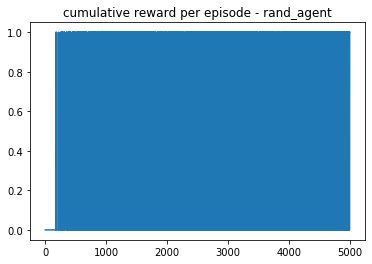

In [25]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [26]:
mc_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

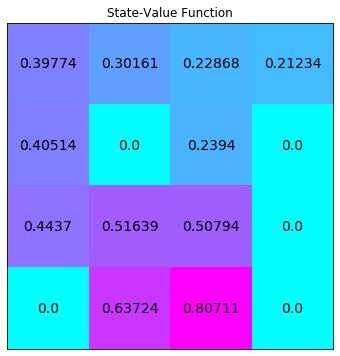

In [27]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [28]:
V.sum()

4.697290644685594

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [108]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += None #complete here
    return V

In [109]:
#Done: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha
    return V

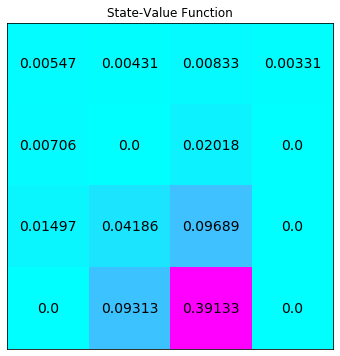

In [110]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [111]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 1.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 334 - cum reward 0.0
episode: 335 - cum reward 0.0
episode: 336 - cum reward 0.0
episode: 337 - cum reward 0.0
episode: 338 - cum reward 0.0
episode: 339 - cum reward 0.0
episode: 340 - cum reward 0.0
episode: 341 - cum reward 0.0
episode: 342 - cum reward 1.0
episode: 343 - cum reward 0.0
episode: 344 - cum reward 0.0
episode: 345 - cum reward 0.0
episode: 346 - cum reward 0.0
episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 1.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 1.0
episode: 3

episode: 668 - cum reward 0.0
episode: 669 - cum reward 0.0
episode: 670 - cum reward 0.0
episode: 671 - cum reward 0.0
episode: 672 - cum reward 0.0
episode: 673 - cum reward 0.0
episode: 674 - cum reward 0.0
episode: 675 - cum reward 0.0
episode: 676 - cum reward 0.0
episode: 677 - cum reward 0.0
episode: 678 - cum reward 0.0
episode: 679 - cum reward 0.0
episode: 680 - cum reward 0.0
episode: 681 - cum reward 0.0
episode: 682 - cum reward 0.0
episode: 683 - cum reward 0.0
episode: 684 - cum reward 0.0
episode: 685 - cum reward 0.0
episode: 686 - cum reward 0.0
episode: 687 - cum reward 0.0
episode: 688 - cum reward 0.0
episode: 689 - cum reward 0.0
episode: 690 - cum reward 0.0
episode: 691 - cum reward 0.0
episode: 692 - cum reward 0.0
episode: 693 - cum reward 0.0
episode: 694 - cum reward 0.0
episode: 695 - cum reward 0.0
episode: 696 - cum reward 0.0
episode: 697 - cum reward 0.0
episode: 698 - cum reward 0.0
episode: 699 - cum reward 0.0
episode: 700 - cum reward 0.0
episode: 7

episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 982 - cum reward 0.0
episode: 983 - cum reward 0.0
episode: 984 - cum reward 0.0
episode: 985 - cum reward 0.0
episode: 986 - cum reward 0.0
episode: 987 - cum reward 0.0
episode: 988 - cum reward 0.0
episode: 989 - cum reward 0.0
episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 1.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.

episode: 1247 - cum reward 0.0
episode: 1248 - cum reward 0.0
episode: 1249 - cum reward 0.0
episode: 1250 - cum reward 0.0
episode: 1251 - cum reward 0.0
episode: 1252 - cum reward 0.0
episode: 1253 - cum reward 0.0
episode: 1254 - cum reward 1.0
episode: 1255 - cum reward 0.0
episode: 1256 - cum reward 0.0
episode: 1257 - cum reward 0.0
episode: 1258 - cum reward 0.0
episode: 1259 - cum reward 0.0
episode: 1260 - cum reward 0.0
episode: 1261 - cum reward 0.0
episode: 1262 - cum reward 0.0
episode: 1263 - cum reward 0.0
episode: 1264 - cum reward 0.0
episode: 1265 - cum reward 0.0
episode: 1266 - cum reward 0.0
episode: 1267 - cum reward 0.0
episode: 1268 - cum reward 0.0
episode: 1269 - cum reward 0.0
episode: 1270 - cum reward 1.0
episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode: 1273 - cum reward 0.0
episode: 1274 - cum reward 0.0
episode: 1275 - cum reward 0.0
episode: 1276 - cum reward 0.0
episode: 1277 - cum reward 0.0
episode: 1278 - cum reward 0.0
episode:

episode: 1626 - cum reward 1.0
episode: 1627 - cum reward 1.0
episode: 1628 - cum reward 0.0
episode: 1629 - cum reward 1.0
episode: 1630 - cum reward 0.0
episode: 1631 - cum reward 0.0
episode: 1632 - cum reward 0.0
episode: 1633 - cum reward 0.0
episode: 1634 - cum reward 0.0
episode: 1635 - cum reward 0.0
episode: 1636 - cum reward 0.0
episode: 1637 - cum reward 0.0
episode: 1638 - cum reward 0.0
episode: 1639 - cum reward 0.0
episode: 1640 - cum reward 0.0
episode: 1641 - cum reward 0.0
episode: 1642 - cum reward 0.0
episode: 1643 - cum reward 0.0
episode: 1644 - cum reward 0.0
episode: 1645 - cum reward 0.0
episode: 1646 - cum reward 0.0
episode: 1647 - cum reward 0.0
episode: 1648 - cum reward 0.0
episode: 1649 - cum reward 0.0
episode: 1650 - cum reward 0.0
episode: 1651 - cum reward 0.0
episode: 1652 - cum reward 0.0
episode: 1653 - cum reward 0.0
episode: 1654 - cum reward 0.0
episode: 1655 - cum reward 0.0
episode: 1656 - cum reward 1.0
episode: 1657 - cum reward 0.0
episode:

episode: 1961 - cum reward 0.0
episode: 1962 - cum reward 0.0
episode: 1963 - cum reward 0.0
episode: 1964 - cum reward 0.0
episode: 1965 - cum reward 0.0
episode: 1966 - cum reward 0.0
episode: 1967 - cum reward 0.0
episode: 1968 - cum reward 0.0
episode: 1969 - cum reward 0.0
episode: 1970 - cum reward 0.0
episode: 1971 - cum reward 0.0
episode: 1972 - cum reward 0.0
episode: 1973 - cum reward 0.0
episode: 1974 - cum reward 0.0
episode: 1975 - cum reward 0.0
episode: 1976 - cum reward 0.0
episode: 1977 - cum reward 0.0
episode: 1978 - cum reward 0.0
episode: 1979 - cum reward 0.0
episode: 1980 - cum reward 0.0
episode: 1981 - cum reward 0.0
episode: 1982 - cum reward 0.0
episode: 1983 - cum reward 0.0
episode: 1984 - cum reward 0.0
episode: 1985 - cum reward 0.0
episode: 1986 - cum reward 0.0
episode: 1987 - cum reward 0.0
episode: 1988 - cum reward 0.0
episode: 1989 - cum reward 0.0
episode: 1990 - cum reward 0.0
episode: 1991 - cum reward 0.0
episode: 1992 - cum reward 0.0
episode:

episode: 2313 - cum reward 1.0
episode: 2314 - cum reward 0.0
episode: 2315 - cum reward 1.0
episode: 2316 - cum reward 0.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 0.0
episode: 2321 - cum reward 0.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 1.0
episode: 2324 - cum reward 0.0
episode: 2325 - cum reward 0.0
episode: 2326 - cum reward 0.0
episode: 2327 - cum reward 0.0
episode: 2328 - cum reward 0.0
episode: 2329 - cum reward 0.0
episode: 2330 - cum reward 0.0
episode: 2331 - cum reward 0.0
episode: 2332 - cum reward 0.0
episode: 2333 - cum reward 0.0
episode: 2334 - cum reward 0.0
episode: 2335 - cum reward 1.0
episode: 2336 - cum reward 0.0
episode: 2337 - cum reward 0.0
episode: 2338 - cum reward 0.0
episode: 2339 - cum reward 0.0
episode: 2340 - cum reward 0.0
episode: 2341 - cum reward 0.0
episode: 2342 - cum reward 0.0
episode: 2343 - cum reward 1.0
episode: 2344 - cum reward 0.0
episode:

episode: 2642 - cum reward 0.0
episode: 2643 - cum reward 0.0
episode: 2644 - cum reward 0.0
episode: 2645 - cum reward 0.0
episode: 2646 - cum reward 0.0
episode: 2647 - cum reward 0.0
episode: 2648 - cum reward 0.0
episode: 2649 - cum reward 0.0
episode: 2650 - cum reward 1.0
episode: 2651 - cum reward 0.0
episode: 2652 - cum reward 0.0
episode: 2653 - cum reward 0.0
episode: 2654 - cum reward 0.0
episode: 2655 - cum reward 0.0
episode: 2656 - cum reward 0.0
episode: 2657 - cum reward 0.0
episode: 2658 - cum reward 0.0
episode: 2659 - cum reward 0.0
episode: 2660 - cum reward 0.0
episode: 2661 - cum reward 0.0
episode: 2662 - cum reward 0.0
episode: 2663 - cum reward 0.0
episode: 2664 - cum reward 0.0
episode: 2665 - cum reward 0.0
episode: 2666 - cum reward 0.0
episode: 2667 - cum reward 0.0
episode: 2668 - cum reward 0.0
episode: 2669 - cum reward 1.0
episode: 2670 - cum reward 0.0
episode: 2671 - cum reward 0.0
episode: 2672 - cum reward 0.0
episode: 2673 - cum reward 0.0
episode:

episode: 2964 - cum reward 0.0
episode: 2965 - cum reward 0.0
episode: 2966 - cum reward 0.0
episode: 2967 - cum reward 0.0
episode: 2968 - cum reward 0.0
episode: 2969 - cum reward 0.0
episode: 2970 - cum reward 1.0
episode: 2971 - cum reward 1.0
episode: 2972 - cum reward 0.0
episode: 2973 - cum reward 1.0
episode: 2974 - cum reward 0.0
episode: 2975 - cum reward 0.0
episode: 2976 - cum reward 0.0
episode: 2977 - cum reward 0.0
episode: 2978 - cum reward 0.0
episode: 2979 - cum reward 0.0
episode: 2980 - cum reward 0.0
episode: 2981 - cum reward 0.0
episode: 2982 - cum reward 0.0
episode: 2983 - cum reward 0.0
episode: 2984 - cum reward 0.0
episode: 2985 - cum reward 0.0
episode: 2986 - cum reward 0.0
episode: 2987 - cum reward 0.0
episode: 2988 - cum reward 1.0
episode: 2989 - cum reward 0.0
episode: 2990 - cum reward 0.0
episode: 2991 - cum reward 0.0
episode: 2992 - cum reward 0.0
episode: 2993 - cum reward 0.0
episode: 2994 - cum reward 0.0
episode: 2995 - cum reward 0.0
episode:

episode: 3269 - cum reward 0.0
episode: 3270 - cum reward 0.0
episode: 3271 - cum reward 0.0
episode: 3272 - cum reward 0.0
episode: 3273 - cum reward 1.0
episode: 3274 - cum reward 0.0
episode: 3275 - cum reward 0.0
episode: 3276 - cum reward 0.0
episode: 3277 - cum reward 0.0
episode: 3278 - cum reward 0.0
episode: 3279 - cum reward 1.0
episode: 3280 - cum reward 0.0
episode: 3281 - cum reward 0.0
episode: 3282 - cum reward 0.0
episode: 3283 - cum reward 0.0
episode: 3284 - cum reward 0.0
episode: 3285 - cum reward 1.0
episode: 3286 - cum reward 0.0
episode: 3287 - cum reward 1.0
episode: 3288 - cum reward 1.0
episode: 3289 - cum reward 0.0
episode: 3290 - cum reward 0.0
episode: 3291 - cum reward 0.0
episode: 3292 - cum reward 1.0
episode: 3293 - cum reward 0.0
episode: 3294 - cum reward 0.0
episode: 3295 - cum reward 1.0
episode: 3296 - cum reward 0.0
episode: 3297 - cum reward 0.0
episode: 3298 - cum reward 1.0
episode: 3299 - cum reward 0.0
episode: 3300 - cum reward 0.0
episode:

episode: 3559 - cum reward 0.0
episode: 3560 - cum reward 0.0
episode: 3561 - cum reward 0.0
episode: 3562 - cum reward 0.0
episode: 3563 - cum reward 0.0
episode: 3564 - cum reward 0.0
episode: 3565 - cum reward 0.0
episode: 3566 - cum reward 0.0
episode: 3567 - cum reward 0.0
episode: 3568 - cum reward 0.0
episode: 3569 - cum reward 0.0
episode: 3570 - cum reward 1.0
episode: 3571 - cum reward 0.0
episode: 3572 - cum reward 0.0
episode: 3573 - cum reward 1.0
episode: 3574 - cum reward 0.0
episode: 3575 - cum reward 0.0
episode: 3576 - cum reward 0.0
episode: 3577 - cum reward 0.0
episode: 3578 - cum reward 0.0
episode: 3579 - cum reward 0.0
episode: 3580 - cum reward 0.0
episode: 3581 - cum reward 0.0
episode: 3582 - cum reward 0.0
episode: 3583 - cum reward 0.0
episode: 3584 - cum reward 0.0
episode: 3585 - cum reward 0.0
episode: 3586 - cum reward 0.0
episode: 3587 - cum reward 1.0
episode: 3588 - cum reward 0.0
episode: 3589 - cum reward 0.0
episode: 3590 - cum reward 0.0
episode:

episode: 3858 - cum reward 0.0
episode: 3859 - cum reward 0.0
episode: 3860 - cum reward 0.0
episode: 3861 - cum reward 0.0
episode: 3862 - cum reward 0.0
episode: 3863 - cum reward 0.0
episode: 3864 - cum reward 0.0
episode: 3865 - cum reward 0.0
episode: 3866 - cum reward 0.0
episode: 3867 - cum reward 0.0
episode: 3868 - cum reward 1.0
episode: 3869 - cum reward 0.0
episode: 3870 - cum reward 1.0
episode: 3871 - cum reward 0.0
episode: 3872 - cum reward 0.0
episode: 3873 - cum reward 1.0
episode: 3874 - cum reward 0.0
episode: 3875 - cum reward 0.0
episode: 3876 - cum reward 1.0
episode: 3877 - cum reward 0.0
episode: 3878 - cum reward 0.0
episode: 3879 - cum reward 0.0
episode: 3880 - cum reward 0.0
episode: 3881 - cum reward 0.0
episode: 3882 - cum reward 0.0
episode: 3883 - cum reward 0.0
episode: 3884 - cum reward 0.0
episode: 3885 - cum reward 0.0
episode: 3886 - cum reward 0.0
episode: 3887 - cum reward 0.0
episode: 3888 - cum reward 0.0
episode: 3889 - cum reward 0.0
episode:

episode: 4159 - cum reward 0.0
episode: 4160 - cum reward 1.0
episode: 4161 - cum reward 0.0
episode: 4162 - cum reward 0.0
episode: 4163 - cum reward 0.0
episode: 4164 - cum reward 1.0
episode: 4165 - cum reward 0.0
episode: 4166 - cum reward 1.0
episode: 4167 - cum reward 0.0
episode: 4168 - cum reward 0.0
episode: 4169 - cum reward 0.0
episode: 4170 - cum reward 0.0
episode: 4171 - cum reward 0.0
episode: 4172 - cum reward 0.0
episode: 4173 - cum reward 1.0
episode: 4174 - cum reward 0.0
episode: 4175 - cum reward 0.0
episode: 4176 - cum reward 0.0
episode: 4177 - cum reward 0.0
episode: 4178 - cum reward 0.0
episode: 4179 - cum reward 0.0
episode: 4180 - cum reward 0.0
episode: 4181 - cum reward 0.0
episode: 4182 - cum reward 0.0
episode: 4183 - cum reward 0.0
episode: 4184 - cum reward 0.0
episode: 4185 - cum reward 1.0
episode: 4186 - cum reward 0.0
episode: 4187 - cum reward 0.0
episode: 4188 - cum reward 0.0
episode: 4189 - cum reward 1.0
episode: 4190 - cum reward 0.0
episode:

episode: 4446 - cum reward 1.0
episode: 4447 - cum reward 0.0
episode: 4448 - cum reward 1.0
episode: 4449 - cum reward 1.0
episode: 4450 - cum reward 0.0
episode: 4451 - cum reward 1.0
episode: 4452 - cum reward 0.0
episode: 4453 - cum reward 0.0
episode: 4454 - cum reward 0.0
episode: 4455 - cum reward 0.0
episode: 4456 - cum reward 0.0
episode: 4457 - cum reward 0.0
episode: 4458 - cum reward 0.0
episode: 4459 - cum reward 0.0
episode: 4460 - cum reward 0.0
episode: 4461 - cum reward 0.0
episode: 4462 - cum reward 0.0
episode: 4463 - cum reward 0.0
episode: 4464 - cum reward 0.0
episode: 4465 - cum reward 1.0
episode: 4466 - cum reward 0.0
episode: 4467 - cum reward 1.0
episode: 4468 - cum reward 0.0
episode: 4469 - cum reward 0.0
episode: 4470 - cum reward 1.0
episode: 4471 - cum reward 1.0
episode: 4472 - cum reward 0.0
episode: 4473 - cum reward 0.0
episode: 4474 - cum reward 0.0
episode: 4475 - cum reward 1.0
episode: 4476 - cum reward 1.0
episode: 4477 - cum reward 0.0
episode:

episode: 4716 - cum reward 0.0
episode: 4717 - cum reward 0.0
episode: 4718 - cum reward 1.0
episode: 4719 - cum reward 0.0
episode: 4720 - cum reward 0.0
episode: 4721 - cum reward 1.0
episode: 4722 - cum reward 0.0
episode: 4723 - cum reward 0.0
episode: 4724 - cum reward 0.0
episode: 4725 - cum reward 0.0
episode: 4726 - cum reward 1.0
episode: 4727 - cum reward 1.0
episode: 4728 - cum reward 0.0
episode: 4729 - cum reward 0.0
episode: 4730 - cum reward 1.0
episode: 4731 - cum reward 1.0
episode: 4732 - cum reward 0.0
episode: 4733 - cum reward 0.0
episode: 4734 - cum reward 0.0
episode: 4735 - cum reward 1.0
episode: 4736 - cum reward 1.0
episode: 4737 - cum reward 0.0
episode: 4738 - cum reward 0.0
episode: 4739 - cum reward 1.0
episode: 4740 - cum reward 0.0
episode: 4741 - cum reward 0.0
episode: 4742 - cum reward 0.0
episode: 4743 - cum reward 1.0
episode: 4744 - cum reward 0.0
episode: 4745 - cum reward 1.0
episode: 4746 - cum reward 1.0
episode: 4747 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

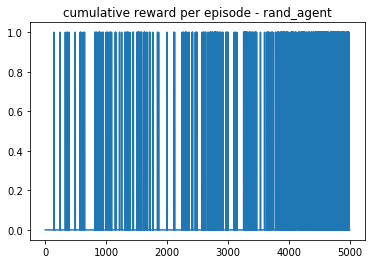

In [112]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [113]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

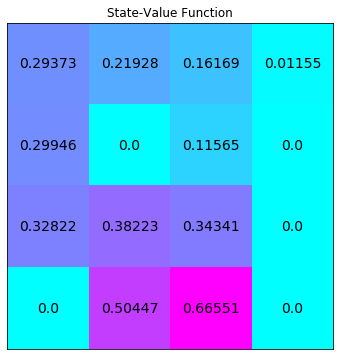

In [114]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [115]:
V.sum()

3.325186151719009

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [116]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        pass #complete here
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

In [117]:
#Done: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 1.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 1.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 1.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 0.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 1.0
episode: 319 - cum reward 1.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 1.0
episode: 323 - cum reward 1.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 1.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 330 - cum reward 0.0
episode: 331 - cum reward 0.0
episode: 332 - cum reward 0.0
episode: 333 - cum reward 0.0
episode: 334 - cum reward 0.0
episode: 335 - cum reward 1.0
episode: 336 - cum reward 0.0
episode: 337 - cum reward 0.0
episode: 338 - cum reward 1.0
episode: 3

episode: 597 - cum reward 1.0
episode: 598 - cum reward 0.0
episode: 599 - cum reward 0.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 0.0
episode: 602 - cum reward 0.0
episode: 603 - cum reward 1.0
episode: 604 - cum reward 0.0
episode: 605 - cum reward 1.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 1.0
episode: 608 - cum reward 1.0
episode: 609 - cum reward 1.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 0.0
episode: 615 - cum reward 1.0
episode: 616 - cum reward 1.0
episode: 617 - cum reward 1.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 0.0
episode: 620 - cum reward 0.0
episode: 621 - cum reward 1.0
episode: 622 - cum reward 1.0
episode: 623 - cum reward 0.0
episode: 624 - cum reward 1.0
episode: 625 - cum reward 0.0
episode: 626 - cum reward 0.0
episode: 627 - cum reward 0.0
episode: 628 - cum reward 0.0
episode: 629 - cum reward 0.0
episode: 6

episode: 880 - cum reward 0.0
episode: 881 - cum reward 0.0
episode: 882 - cum reward 0.0
episode: 883 - cum reward 0.0
episode: 884 - cum reward 0.0
episode: 885 - cum reward 1.0
episode: 886 - cum reward 0.0
episode: 887 - cum reward 1.0
episode: 888 - cum reward 0.0
episode: 889 - cum reward 0.0
episode: 890 - cum reward 0.0
episode: 891 - cum reward 0.0
episode: 892 - cum reward 1.0
episode: 893 - cum reward 0.0
episode: 894 - cum reward 0.0
episode: 895 - cum reward 0.0
episode: 896 - cum reward 1.0
episode: 897 - cum reward 1.0
episode: 898 - cum reward 0.0
episode: 899 - cum reward 0.0
episode: 900 - cum reward 0.0
episode: 901 - cum reward 0.0
episode: 902 - cum reward 1.0
episode: 903 - cum reward 0.0
episode: 904 - cum reward 0.0
episode: 905 - cum reward 0.0
episode: 906 - cum reward 1.0
episode: 907 - cum reward 1.0
episode: 908 - cum reward 1.0
episode: 909 - cum reward 0.0
episode: 910 - cum reward 0.0
episode: 911 - cum reward 0.0
episode: 912 - cum reward 0.0
episode: 9

episode: 1176 - cum reward 0.0
episode: 1177 - cum reward 0.0
episode: 1178 - cum reward 1.0
episode: 1179 - cum reward 1.0
episode: 1180 - cum reward 0.0
episode: 1181 - cum reward 1.0
episode: 1182 - cum reward 0.0
episode: 1183 - cum reward 1.0
episode: 1184 - cum reward 0.0
episode: 1185 - cum reward 0.0
episode: 1186 - cum reward 1.0
episode: 1187 - cum reward 0.0
episode: 1188 - cum reward 0.0
episode: 1189 - cum reward 0.0
episode: 1190 - cum reward 1.0
episode: 1191 - cum reward 0.0
episode: 1192 - cum reward 0.0
episode: 1193 - cum reward 0.0
episode: 1194 - cum reward 1.0
episode: 1195 - cum reward 0.0
episode: 1196 - cum reward 0.0
episode: 1197 - cum reward 1.0
episode: 1198 - cum reward 1.0
episode: 1199 - cum reward 0.0
episode: 1200 - cum reward 1.0
episode: 1201 - cum reward 1.0
episode: 1202 - cum reward 1.0
episode: 1203 - cum reward 1.0
episode: 1204 - cum reward 0.0
episode: 1205 - cum reward 0.0
episode: 1206 - cum reward 0.0
episode: 1207 - cum reward 0.0
episode:

episode: 1447 - cum reward 1.0
episode: 1448 - cum reward 1.0
episode: 1449 - cum reward 0.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 0.0
episode: 1452 - cum reward 0.0
episode: 1453 - cum reward 1.0
episode: 1454 - cum reward 1.0
episode: 1455 - cum reward 0.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode: 1458 - cum reward 1.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 0.0
episode: 1461 - cum reward 0.0
episode: 1462 - cum reward 1.0
episode: 1463 - cum reward 0.0
episode: 1464 - cum reward 1.0
episode: 1465 - cum reward 0.0
episode: 1466 - cum reward 1.0
episode: 1467 - cum reward 0.0
episode: 1468 - cum reward 0.0
episode: 1469 - cum reward 0.0
episode: 1470 - cum reward 0.0
episode: 1471 - cum reward 0.0
episode: 1472 - cum reward 0.0
episode: 1473 - cum reward 1.0
episode: 1474 - cum reward 0.0
episode: 1475 - cum reward 0.0
episode: 1476 - cum reward 0.0
episode: 1477 - cum reward 1.0
episode: 1478 - cum reward 0.0
episode:

episode: 1727 - cum reward 0.0
episode: 1728 - cum reward 0.0
episode: 1729 - cum reward 0.0
episode: 1730 - cum reward 1.0
episode: 1731 - cum reward 1.0
episode: 1732 - cum reward 1.0
episode: 1733 - cum reward 0.0
episode: 1734 - cum reward 0.0
episode: 1735 - cum reward 0.0
episode: 1736 - cum reward 0.0
episode: 1737 - cum reward 0.0
episode: 1738 - cum reward 0.0
episode: 1739 - cum reward 0.0
episode: 1740 - cum reward 1.0
episode: 1741 - cum reward 1.0
episode: 1742 - cum reward 0.0
episode: 1743 - cum reward 1.0
episode: 1744 - cum reward 0.0
episode: 1745 - cum reward 1.0
episode: 1746 - cum reward 0.0
episode: 1747 - cum reward 0.0
episode: 1748 - cum reward 0.0
episode: 1749 - cum reward 0.0
episode: 1750 - cum reward 0.0
episode: 1751 - cum reward 1.0
episode: 1752 - cum reward 1.0
episode: 1753 - cum reward 0.0
episode: 1754 - cum reward 0.0
episode: 1755 - cum reward 0.0
episode: 1756 - cum reward 0.0
episode: 1757 - cum reward 1.0
episode: 1758 - cum reward 1.0
episode:

episode: 2000 - cum reward 0.0
episode: 2001 - cum reward 1.0
episode: 2002 - cum reward 0.0
episode: 2003 - cum reward 1.0
episode: 2004 - cum reward 0.0
episode: 2005 - cum reward 0.0
episode: 2006 - cum reward 1.0
episode: 2007 - cum reward 0.0
episode: 2008 - cum reward 0.0
episode: 2009 - cum reward 0.0
episode: 2010 - cum reward 0.0
episode: 2011 - cum reward 1.0
episode: 2012 - cum reward 1.0
episode: 2013 - cum reward 1.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 1.0
episode: 2017 - cum reward 1.0
episode: 2018 - cum reward 0.0
episode: 2019 - cum reward 0.0
episode: 2020 - cum reward 0.0
episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 0.0
episode: 2023 - cum reward 0.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 1.0
episode: 2026 - cum reward 1.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 1.0
episode: 2029 - cum reward 0.0
episode: 2030 - cum reward 1.0
episode: 2031 - cum reward 0.0
episode:

episode: 2272 - cum reward 0.0
episode: 2273 - cum reward 0.0
episode: 2274 - cum reward 0.0
episode: 2275 - cum reward 0.0
episode: 2276 - cum reward 1.0
episode: 2277 - cum reward 0.0
episode: 2278 - cum reward 1.0
episode: 2279 - cum reward 1.0
episode: 2280 - cum reward 0.0
episode: 2281 - cum reward 0.0
episode: 2282 - cum reward 0.0
episode: 2283 - cum reward 0.0
episode: 2284 - cum reward 0.0
episode: 2285 - cum reward 0.0
episode: 2286 - cum reward 0.0
episode: 2287 - cum reward 1.0
episode: 2288 - cum reward 0.0
episode: 2289 - cum reward 0.0
episode: 2290 - cum reward 1.0
episode: 2291 - cum reward 0.0
episode: 2292 - cum reward 1.0
episode: 2293 - cum reward 0.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 0.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode:

episode: 2558 - cum reward 1.0
episode: 2559 - cum reward 0.0
episode: 2560 - cum reward 1.0
episode: 2561 - cum reward 1.0
episode: 2562 - cum reward 1.0
episode: 2563 - cum reward 0.0
episode: 2564 - cum reward 0.0
episode: 2565 - cum reward 0.0
episode: 2566 - cum reward 1.0
episode: 2567 - cum reward 1.0
episode: 2568 - cum reward 0.0
episode: 2569 - cum reward 0.0
episode: 2570 - cum reward 1.0
episode: 2571 - cum reward 0.0
episode: 2572 - cum reward 0.0
episode: 2573 - cum reward 1.0
episode: 2574 - cum reward 0.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 0.0
episode: 2578 - cum reward 0.0
episode: 2579 - cum reward 1.0
episode: 2580 - cum reward 1.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 0.0
episode: 2583 - cum reward 0.0
episode: 2584 - cum reward 1.0
episode: 2585 - cum reward 0.0
episode: 2586 - cum reward 1.0
episode: 2587 - cum reward 1.0
episode: 2588 - cum reward 1.0
episode: 2589 - cum reward 0.0
episode:

episode: 2837 - cum reward 1.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 1.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 0.0
episode: 2843 - cum reward 1.0
episode: 2844 - cum reward 1.0
episode: 2845 - cum reward 1.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 1.0
episode: 2849 - cum reward 1.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 1.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 0.0
episode: 2855 - cum reward 0.0
episode: 2856 - cum reward 1.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 1.0
episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 1.0
episode: 2862 - cum reward 1.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 0.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 0.0
episode:

episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 1.0
episode: 3125 - cum reward 1.0
episode: 3126 - cum reward 0.0
episode: 3127 - cum reward 0.0
episode: 3128 - cum reward 0.0
episode: 3129 - cum reward 0.0
episode: 3130 - cum reward 0.0
episode: 3131 - cum reward 0.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 1.0
episode: 3134 - cum reward 0.0
episode: 3135 - cum reward 1.0
episode: 3136 - cum reward 0.0
episode: 3137 - cum reward 1.0
episode: 3138 - cum reward 0.0
episode: 3139 - cum reward 0.0
episode: 3140 - cum reward 1.0
episode: 3141 - cum reward 0.0
episode: 3142 - cum reward 0.0
episode: 3143 - cum reward 0.0
episode: 3144 - cum reward 0.0
episode: 3145 - cum reward 0.0
episode: 3146 - cum reward 0.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 1.0
episode: 3149 - cum reward 0.0
episode: 3150 - cum reward 0.0
episode: 3151 - cum reward 1.0
episode: 3152 - cum reward 0.0
episode: 3153 - cum reward 0.0
episode: 3154 - cum reward 0.0
episode:

episode: 3393 - cum reward 0.0
episode: 3394 - cum reward 0.0
episode: 3395 - cum reward 1.0
episode: 3396 - cum reward 1.0
episode: 3397 - cum reward 1.0
episode: 3398 - cum reward 1.0
episode: 3399 - cum reward 0.0
episode: 3400 - cum reward 1.0
episode: 3401 - cum reward 1.0
episode: 3402 - cum reward 1.0
episode: 3403 - cum reward 1.0
episode: 3404 - cum reward 0.0
episode: 3405 - cum reward 0.0
episode: 3406 - cum reward 0.0
episode: 3407 - cum reward 0.0
episode: 3408 - cum reward 0.0
episode: 3409 - cum reward 1.0
episode: 3410 - cum reward 0.0
episode: 3411 - cum reward 0.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 1.0
episode: 3414 - cum reward 1.0
episode: 3415 - cum reward 1.0
episode: 3416 - cum reward 0.0
episode: 3417 - cum reward 0.0
episode: 3418 - cum reward 0.0
episode: 3419 - cum reward 0.0
episode: 3420 - cum reward 0.0
episode: 3421 - cum reward 0.0
episode: 3422 - cum reward 1.0
episode: 3423 - cum reward 1.0
episode: 3424 - cum reward 0.0
episode:

episode: 3671 - cum reward 0.0
episode: 3672 - cum reward 1.0
episode: 3673 - cum reward 0.0
episode: 3674 - cum reward 0.0
episode: 3675 - cum reward 0.0
episode: 3676 - cum reward 0.0
episode: 3677 - cum reward 1.0
episode: 3678 - cum reward 0.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 1.0
episode: 3681 - cum reward 0.0
episode: 3682 - cum reward 0.0
episode: 3683 - cum reward 0.0
episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 1.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 0.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 0.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 1.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 1.0
episode: 3701 - cum reward 0.0
episode: 3702 - cum reward 0.0
episode:

episode: 3938 - cum reward 1.0
episode: 3939 - cum reward 0.0
episode: 3940 - cum reward 0.0
episode: 3941 - cum reward 0.0
episode: 3942 - cum reward 0.0
episode: 3943 - cum reward 1.0
episode: 3944 - cum reward 0.0
episode: 3945 - cum reward 0.0
episode: 3946 - cum reward 0.0
episode: 3947 - cum reward 0.0
episode: 3948 - cum reward 0.0
episode: 3949 - cum reward 0.0
episode: 3950 - cum reward 0.0
episode: 3951 - cum reward 0.0
episode: 3952 - cum reward 0.0
episode: 3953 - cum reward 0.0
episode: 3954 - cum reward 0.0
episode: 3955 - cum reward 0.0
episode: 3956 - cum reward 0.0
episode: 3957 - cum reward 0.0
episode: 3958 - cum reward 0.0
episode: 3959 - cum reward 1.0
episode: 3960 - cum reward 0.0
episode: 3961 - cum reward 1.0
episode: 3962 - cum reward 0.0
episode: 3963 - cum reward 0.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 1.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 0.0
episode:

episode: 4203 - cum reward 0.0
episode: 4204 - cum reward 0.0
episode: 4205 - cum reward 0.0
episode: 4206 - cum reward 1.0
episode: 4207 - cum reward 1.0
episode: 4208 - cum reward 1.0
episode: 4209 - cum reward 0.0
episode: 4210 - cum reward 0.0
episode: 4211 - cum reward 0.0
episode: 4212 - cum reward 0.0
episode: 4213 - cum reward 0.0
episode: 4214 - cum reward 1.0
episode: 4215 - cum reward 0.0
episode: 4216 - cum reward 0.0
episode: 4217 - cum reward 0.0
episode: 4218 - cum reward 0.0
episode: 4219 - cum reward 1.0
episode: 4220 - cum reward 0.0
episode: 4221 - cum reward 0.0
episode: 4222 - cum reward 0.0
episode: 4223 - cum reward 0.0
episode: 4224 - cum reward 0.0
episode: 4225 - cum reward 0.0
episode: 4226 - cum reward 1.0
episode: 4227 - cum reward 1.0
episode: 4228 - cum reward 0.0
episode: 4229 - cum reward 0.0
episode: 4230 - cum reward 1.0
episode: 4231 - cum reward 0.0
episode: 4232 - cum reward 1.0
episode: 4233 - cum reward 0.0
episode: 4234 - cum reward 0.0
episode:

episode: 4491 - cum reward 0.0
episode: 4492 - cum reward 1.0
episode: 4493 - cum reward 0.0
episode: 4494 - cum reward 1.0
episode: 4495 - cum reward 1.0
episode: 4496 - cum reward 1.0
episode: 4497 - cum reward 0.0
episode: 4498 - cum reward 1.0
episode: 4499 - cum reward 1.0
episode: 4500 - cum reward 1.0
episode: 4501 - cum reward 0.0
episode: 4502 - cum reward 1.0
episode: 4503 - cum reward 0.0
episode: 4504 - cum reward 0.0
episode: 4505 - cum reward 0.0
episode: 4506 - cum reward 0.0
episode: 4507 - cum reward 0.0
episode: 4508 - cum reward 1.0
episode: 4509 - cum reward 1.0
episode: 4510 - cum reward 1.0
episode: 4511 - cum reward 0.0
episode: 4512 - cum reward 0.0
episode: 4513 - cum reward 0.0
episode: 4514 - cum reward 0.0
episode: 4515 - cum reward 1.0
episode: 4516 - cum reward 0.0
episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 0.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 0.0
episode:

episode: 4760 - cum reward 0.0
episode: 4761 - cum reward 0.0
episode: 4762 - cum reward 0.0
episode: 4763 - cum reward 1.0
episode: 4764 - cum reward 0.0
episode: 4765 - cum reward 1.0
episode: 4766 - cum reward 0.0
episode: 4767 - cum reward 0.0
episode: 4768 - cum reward 0.0
episode: 4769 - cum reward 0.0
episode: 4770 - cum reward 0.0
episode: 4771 - cum reward 1.0
episode: 4772 - cum reward 0.0
episode: 4773 - cum reward 0.0
episode: 4774 - cum reward 0.0
episode: 4775 - cum reward 0.0
episode: 4776 - cum reward 1.0
episode: 4777 - cum reward 0.0
episode: 4778 - cum reward 1.0
episode: 4779 - cum reward 1.0
episode: 4780 - cum reward 1.0
episode: 4781 - cum reward 0.0
episode: 4782 - cum reward 0.0
episode: 4783 - cum reward 0.0
episode: 4784 - cum reward 0.0
episode: 4785 - cum reward 0.0
episode: 4786 - cum reward 0.0
episode: 4787 - cum reward 0.0
episode: 4788 - cum reward 0.0
episode: 4789 - cum reward 1.0
episode: 4790 - cum reward 0.0
episode: 4791 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

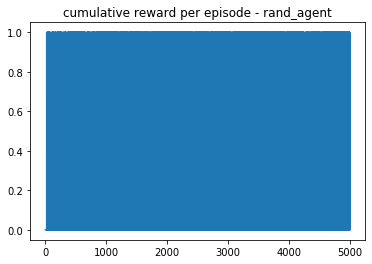

In [118]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [119]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025]])

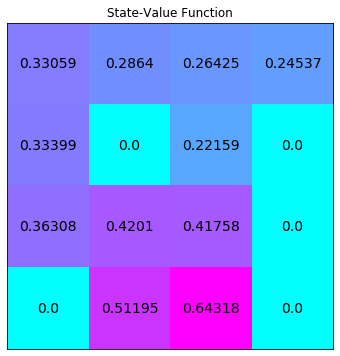

In [120]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [121]:
V.sum()

4.038063463122946

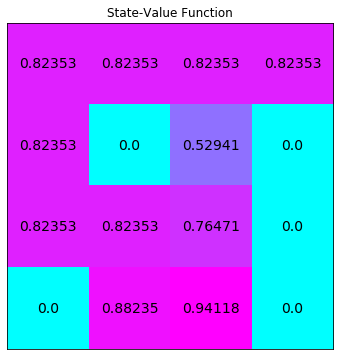

8.882351322605881

In [124]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

In [125]:
#Question: Why we don't have the optimal policy?

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}